In [ ]:
from ultralytics import YOLO
model = YOLO('/content/drive/MyDrive/model/best.onnx')

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify', or 'pose'.


In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv
import numpy as np

In [ ]:
frame ="/content/frames_84ho0sdHiQo_17.jpg"
result = model(frame, agnostic_nms=True)[0]
detections = sv.Detections.from_ultralytics(result)
#


image 1/1 /content/frames_84ho0sdHiQo_17.jpg: 640x640 4 player_names, 5 player_positions, 1097.8ms
Speed: 2.9ms preprocess, 1097.8ms inference, 38.3ms postprocess per image at shape (1, 3, 640, 640)


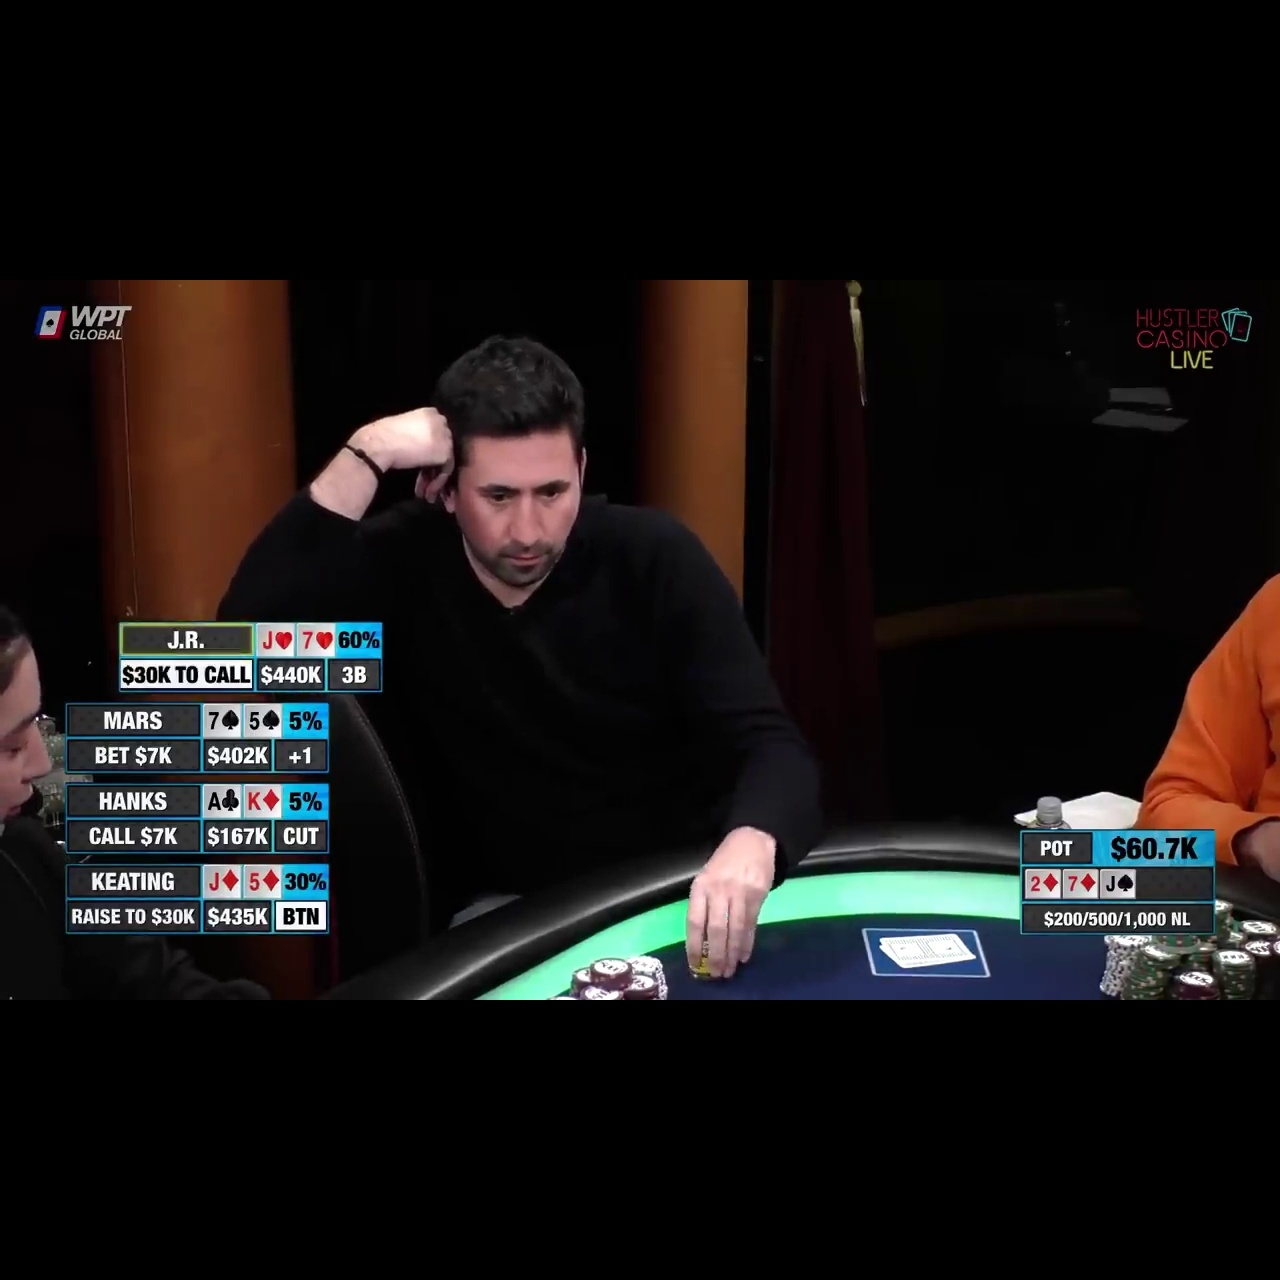

In [ ]:
image_path = "/content/frames_84ho0sdHiQo_17.jpg"
image = read_image(image_path)
image

In [ ]:
import cv2
import os


# 'xyxy' contains bounding box coordinates [xmin, ymin, xmax, ymax]

image_path = '/content/frames_84ho0sdHiQo_17.jpg'  # Replace with your image path
image = cv2.imread(image_path)



# Check if there is at least one detection
if detections.xyxy.shape[0] > 0:
    saved_images = {"player_name": [], "player_position": []}

    for i, (bbox, class_id, conf) in enumerate(zip(detections.xyxy, detections.class_id, detections.confidence)):
        # bounding box coordinates
        xmin, ymin, xmax, ymax = map(int, bbox)

        # coordinates
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(image.shape[1], xmax)
        ymax = min(image.shape[0], ymax)

        # confidence is greater than 0.5
        if conf > 0.5:
            # Save each cropped image with a unique filename based on class ID
            filename = f'cropped_image_class_{class_id}_box_{i}.jpg'
            saved_images["player_name" if class_id == 0 else "player_position"].append(filename)
            cv2.imwrite(filename, image[ymin:ymax, xmin:xmax])

    # Process the saved images using TrOCR
    player_names = []
    player_positions = []

    for player_name_image, player_position_image in zip(saved_images["player_name"], saved_images["player_position"]):


        player_name_text = ocr(Image.open(player_name_image).convert('RGB'), processor, model_l)


        player_names.append(player_name_text.strip())


        player_position_text = ocr(Image.open(player_position_image).convert('RGB'), processor, model_l)
        player_positions.append(player_position_text.strip())


    player_mapping = dict(zip(player_names, player_positions))


    print("Mapped Player Names to Positions:")
    for player_name, player_position in player_mapping.items():
        print(f"{player_name}: {player_position}")

else:
    print("No detections found.")


Mapped Player Names to Positions:
JR.: 3B
KEATING: BTN
MARS: +1
HANIS: CUT


In [ ]:

device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from tqdm.auto import tqdm
from urllib.request import urlretrieve
from zipfile import ZipFile


import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import glob

In [ ]:
def read_image(image_path):
    """
    :param image_path: String, path to the input image.


    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

In [ ]:
def ocr(image, processor, model):
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [ ]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed')
model_l = VisionEncoderDecoderModel.from_pretrained(
    'microsoft/trocr-small-printed'
).to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
